# Computing optimal policies through value iteration

<a href="https://youtu.be/qxMvyV95Sq8">
  <img src="https://img.shields.io/badge/youtube-firebrick?style=for-the-badge&logo=youtube&logoColor=white" alt="YouTube Badge"/>
</a>

<p style="font-size:10px">This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) license.</p>

<p style="font-size:10px">Kamila Zdybał, <a href="https://kamilazdybal.github.io/">Science Docs</a>, 2025</p>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def plot_environment(quantity, n_x, n_y, origin='upper', figsize=(4,3), annotate=True, annotation=None, cmap='coolwarm', vmin=-1, vmax=1, fontsize=20):

    plt.figure(figsize=figsize)
    plt.imshow(quantity, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)
    for axis in ['top', 'bottom', 'left', 'right']:
        plt.gca().spines[axis].set_linewidth(4)
    plt.gca().set_xticks(np.arange(n_x + 1) - .5, minor=True)
    plt.gca().set_yticks(np.arange(n_y + 1) - .5, minor=True)
    plt.xticks([i for i in range(0,n_x)], fontsize=fontsize)
    plt.yticks([i for i in range(0,n_y)], fontsize=fontsize)
    plt.gca().grid(which="minor", color="black", linewidth=1)
    plt.gca().tick_params(which="minor", bottom=False, left=False)
    if annotate:
        for i in range(n_y):
            for j in range(n_x):
                text = plt.text(j, i, round(quantity[i, j], 3), fontsize=fontsize, ha="center", va="center", color="w")

    if annotation is not None:
        for i in range(n_y):
            for j in range(n_x):
                text = plt.text(j, i, str(annotation[i, j]), fontsize=fontsize, ha="center", va="center", color="w")
    
    return plt

***

## Computing optimal policies through value iteration

In [3]:
figsize = (10,5)

In [4]:
discount = 0.9

In [5]:
n_x = 6
n_y = 4
environment = np.zeros((n_y, n_x))

The two terminal states:

In [6]:
location_positive_reward = (0,5)
location_negative_reward = (3,5)

In [7]:
positive_reward = 1.0
negative_reward = -1.0

In [8]:
actions = {0: (-1, 0),  # go up
           1: (1, 0),   # go down
           2: (0, -1),  # go left
           3: (0, 1)}   # go right

In [9]:
action_to_str = {0: r'$\uparrow$',
                 1: r'$\downarrow$',
                 2: r'$\leftarrow$',
                 3: r'$\rightarrow$'}

In [10]:
convergence_threshold = 1e-8

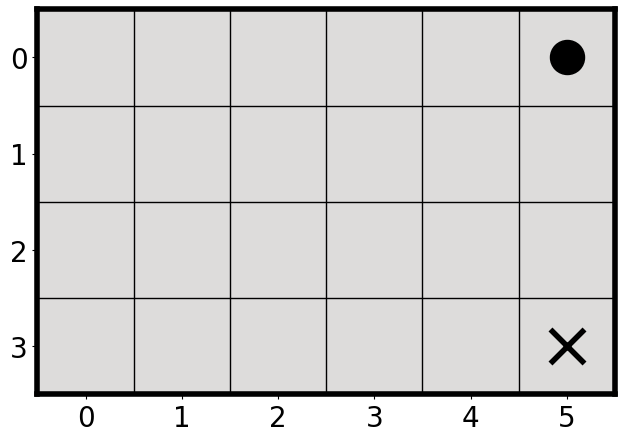

In [11]:
plt = plot_environment(environment, n_x, n_y, figsize=figsize, annotate=False)
plt.scatter(location_positive_reward[1], location_positive_reward[0], s=600, c='k')
plt.scatter(location_negative_reward[1], location_negative_reward[0], s=600, c='k', marker='x', lw=4)
plt.savefig('generalized-environment.svg', dpi=300, bbox_inches='tight', transparent=True)

In [12]:
def execute_action(state, action):

    state_y, state_x = state

    # Terminal state (+1) reward:
    if state == location_positive_reward:
        return state

    # Terminal state (-1) reward:
    elif state == location_negative_reward:
        return state

    # Execute action:
    (a_y, a_x) = actions[action]
    next_state_y, next_state_x = state_y + a_y, state_x + a_x

    # Ensure the agent does not leave the environment:
    if next_state_y < 0 or next_state_y >= n_y or next_state_x < 0 or next_state_x >= n_x:
        next_state = state
    else:
        next_state = (next_state_y, next_state_x)

    return next_state

In [13]:
def rewards(state):

    if state == location_positive_reward:
        reward = positive_reward
    elif state == location_negative_reward:
        reward = negative_reward
    else:
        reward = 0
    
    return reward

Initialize the possible states in the environment:

In [14]:
states = [(i, j) for i in range(n_y) for j in range(n_x)]

Initialize the value function, $v^{\pi}(s)$:

In [15]:
value_function = np.zeros((n_y,n_x))

In [16]:
for _ in range(0,100):

    print('Iteration ' + str(_))
    delta = np.zeros((n_y,n_x))
    new_value_function = np.zeros((n_y,n_x))
    
    for state in states:

        if state == location_positive_reward:
            new_value_function[state] = positive_reward
      
        elif state == location_negative_reward:
            new_value_function[state] = negative_reward
            
        else:
 
            v_values = []

            # Loop over all possible actions to find the one that maximizes the value function:
            for action in actions:

                next_state = execute_action(state, action)
                reward = rewards(state)
                v_values.append(reward + discount * value_function[next_state])

            new_value_function[state] = np.max(v_values)

        # Measure the uncertainty in the value function estimate:
        delta[state] = np.abs(new_value_function[state] - value_function[state])
        
    value_function = new_value_function

    print(np.max(delta))
    
    # Check the convergence criterion:
    if np.max(delta) < convergence_threshold:
        break

Iteration 0
1.0
Iteration 1
0.9
Iteration 2
0.81
Iteration 3
0.7290000000000001
Iteration 4
0.6561000000000001
Iteration 5
0.5904900000000002
Iteration 6
0.5314410000000002
Iteration 7
0.47829690000000014
Iteration 8
0.43046721000000016
Iteration 9
0.0


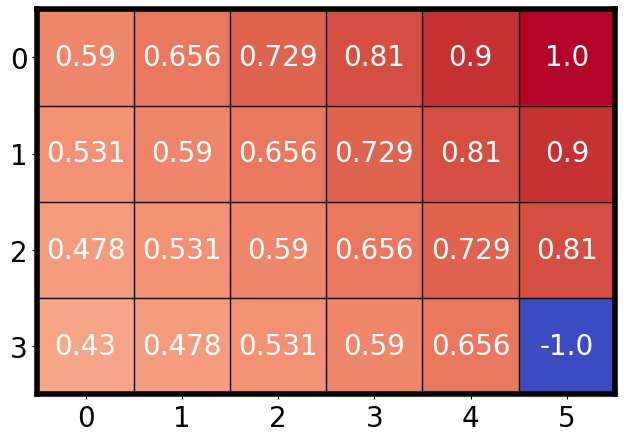

In [17]:
plt = plot_environment(value_function, n_x, n_y, figsize=figsize)
plt.savefig('optimal-value-function.svg', dpi=300, transparent=True, bbox_inches='tight')

Initialize the optimal policy, $\pi^*(s)$:

In [18]:
policy = np.zeros((n_y,n_x))

In [19]:
for state in states:
    
    if state == location_positive_reward or state == location_negative_reward:
        policy[state] = None
        
    else:
        
        best_action = None
        best_value = float('-inf')
        
        for action in actions:
            
            next_state = execute_action(state, action)
            r = rewards(state)
            value = r + discount * value_function[next_state]
            
            if value > best_value:
                best_value = value
                best_action = action
                
        policy[state] = best_action

In [20]:
policy

array([[ 3.,  3.,  3.,  3.,  3., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., nan]])

In [21]:
action_colors = cmc.batlow(np.linspace(0.1, 1, 4))
cmap_actions = ListedColormap(action_colors)

In [22]:
annotation = np.empty((n_y,n_x), dtype='<U30')

for i in range(n_y):
    for j in range(n_x):
        if not np.isnan(policy[i,j]):
            annotation[i, j] = action_to_str[int(policy[i,j])]

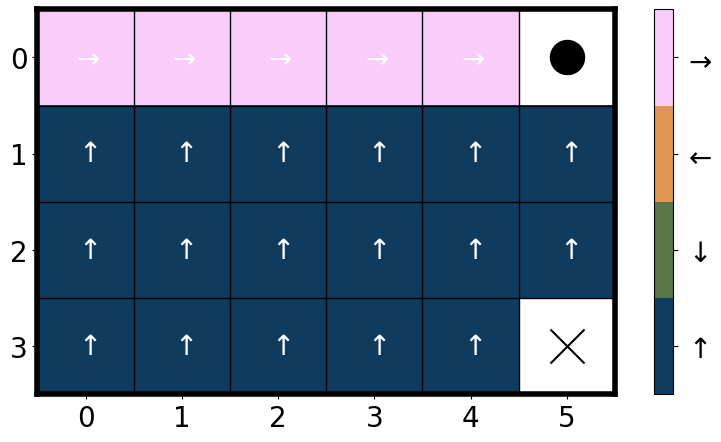

In [23]:
plt = plot_environment(policy, n_x, n_y, annotate=False, annotation=annotation, cmap=cmap_actions, vmin=0, vmax=3, figsize=figsize)
cbar = plt.colorbar()
cbar.set_ticks([3/4*(i+0.5) for i in range(0,4)])
cbar.set_ticklabels(list(action_to_str.values()), fontsize=20)
plt.scatter(location_positive_reward[1], location_positive_reward[0], s=600, c='k')
plt.scatter(location_negative_reward[1], location_negative_reward[0], s=600, c='k', marker='x')
plt.savefig('optimal-policy.png', dpi=300, transparent=True, bbox_inches='tight')

***